### Import the neccessary Libraries

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score
import whisper

## Phase 1

### Training CNN 

#### Convert audio to spectrograms


In [6]:
def audio_to_mel_spectrogram(file_path, save_path=None):
    y, sr = librosa.load(file_path, sr=22050)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    if save_path:
        plt.figure(figsize=(3, 3))
        librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    
    return mel_spec_db

In [7]:
input_dir = "Audio/"
output_dir = "spectrograms/"
os.makedirs(output_dir, exist_ok=True)

for actor_folder in os.listdir(input_dir):
    actor_path = os.path.join(input_dir, actor_folder)
    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            file_path = os.path.join(actor_path, file)
            out_path = os.path.join(output_dir, file.replace(".wav", ".png"))
            audio_to_mel_spectrogram(file_path, save_path=out_path)

C:\Users\pshar\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [8]:
os.listdir("spectrograms")[:5]
# excluding the .ipynb checkpoints there are 1440 spectrograms

['.ipynb_checkpoints',
 '03-01-01-01-01-01-01.png',
 '03-01-01-01-01-01-02.png',
 '03-01-01-01-01-01-03.png',
 '03-01-01-01-01-01-04.png']

In [9]:
len(os.listdir("spectrograms/"))

1441

In [10]:
# the emotion is encoded in the filename itself 
# e.g., 03-01-04-01-01-01-01.png → '04'
# The mapping is given in the kaggle website itself

emotion_map = {
    "01": 0,  # neutral
    "02": 1,  # calm
    "03": 2,  # happy
    "04": 3,  # sad
    "05": 4,  # angry
    "06": 5,  # fearful
    "07": 6,  # disgust
    "08": 7   # surprised
}

#### Analyse the distribution of emotion files

{'01': 96, '02': 192, '03': 192, '04': 192, '05': 192, '06': 192, '07': 192, '08': 192}


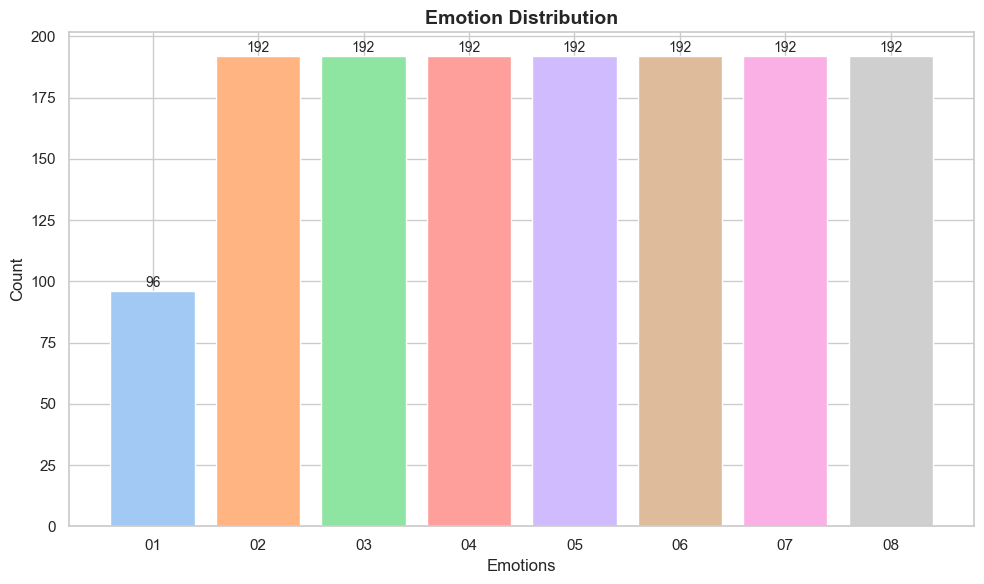

In [12]:
spectogram_dir = "spectrograms/"
files = os.listdir(spectogram_dir)
image_files = [f for f in os.listdir(spectogram_dir) if f.endswith('.png')]
emotion_id = [f.split("-")[2] for f in image_files]

emotion_analysis = {"01": 0, "02": 0, "03": 0, "04": 0, "05": 0, "06": 0, "07": 0, "08": 0}

for emotion in emotion_id:
    emotion_analysis[emotion] += 1

print(emotion_analysis)

import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bars = plt.bar(emotion_analysis.keys(), emotion_analysis.values(), color=sns.color_palette("pastel"))

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.3, f'{yval}', ha='center', va='bottom', fontsize=10)

plt.xlabel("Emotions", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Emotion Distribution", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


#### Create spectogram dataset class for training CNN

In [14]:
class SpectrogramDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, file)
        image = Image.open(img_path).convert("L")  
        emotion_id = file.split("-")[2]           
        label = emotion_map[emotion_id]
        return self.transform(image), label

In [15]:
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten_dim = 32 * 32 * 32  # After two poolings from 128x128
        self.fc1 = nn.Linear(self.flatten_dim, 128)  # Feature layer
        self.fc2 = nn.Linear(128, 8)  # Classifier layer

    def forward(self, x, return_features=False):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 32, 32]
        x = x.view(-1, self.flatten_dim)
        features = F.relu(self.fc1(x))        # [B, 128]
        if return_features:
            return features
        return self.fc2(features)             # [B, 8]

### 1. **Convolutional Layers:**

```python
self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
```

#### Conv1:

* **Number of Input Channels (1)**: The spectrograms are single-channel (grayscale) images therefore the input has one channel. 
* **Number of Output Channels (16)**: The number of filters (output channels) determines how many feature maps (filters) will be generated by the convolution operation. In this case, I chose 16 as a starting point. This number could be adjusted depending on the performance of the model.
* **Kernel Size (3)**: The kernel size determines the size of the filter used for convolution. A kernel size of 3 is very common because it’s small enough to capture local features but still powerful enough to identify meaningful patterns.
* **Padding (1)**: Padding ensures that the spatial dimensions (width and height) of the output are the same as the input. For example, with a kernel of size 3, padding of 1 ensures that the output image after the convolution operation maintains the same height and width as the input.
  
#### Conv2:

* **Number of Input Channels (16)**: The input to this layer is the output from the first convolutional layer, which has 16 channels. So, the number of input channels here is 16.
* **Number of Output Channels (32)**: This layer has 32 filters (channels). The idea is to gradually increase the number of filters as the network goes deeper. More filters allow the network to capture more complex features. This is a common practice in CNN architectures.
* **Kernel Size (3)**

### 2. **Max Pooling:**
```python
self.pool = nn.MaxPool2d(2, 2)
```

* **Pool Size (2x2)**: Max pooling is used to reduce the spatial dimensions (height and width) of the feature maps while retaining important information. It essentially halves the height and width of the feature maps.
* **Stride (2)**: This means the pooling window moves by 2 units at a time, ensuring that the feature maps are downsampled by a factor of 2 after each pooling operation.

### 3. **Fully Connected Layers:**

```python
self.fc1 = nn.Linear(32 * 32 * 32, 128)
self.fc2 = nn.Linear(128, 8)
```


#### fc1:

* **Input Size (32 * 32 * 32)**: After going through two convolutional layers and two pooling operations, the feature map size will be reduced to 32x32. Since the last convolutional layer has 32 output channels, the total input to the fully connected layer will be 32 * 32 * 32 = 32,768. This is the flattened size of the feature map.
* **Output Size (128)**: The number of neurons in the first fully connected layer is chosen to be 128. This number is a compromise between having enough capacity to learn the necessary patterns and keeping the model relatively simple to avoid overfitting. The exact number can be adjusted depending on the performance, but 128 is a reasonable starting point.

#### fc2:

* **Input Size (128)**: The input size is the number of neurons in the previous fully connected layer (128).
* **Output Size (8)**: This is the number of classes (the number of emotions in your dataset). Since we are classifying the audio into 8 emotion categories, the output layer has 8 neurons, each representing one emotion.

### **Walkthrough**

* **Input Image Size**: The input spectrogram is resized to (128, 128) during the creation of the spectrogram dataset. After converting it to a tensor, it will have a shape of (1, 128, 128) (1 channel, 128x128 pixels).

#### Step 1: First Convolution Layer (conv1)

1. **Input**: (1, 128, 128) (1 channel, 128x128 image).
2. **Kernel Size**: 3x3.
3. **Number of Filters**: 16.
4. **Padding**: 1
5. **Output**: After applying the convolution and ReLU activation, the output will have 16 feature maps of size (16, 128, 128).

#### Step 2: Max Pooling

1. **Input**: (16, 128, 128).
2. **Pool Size**: 2x2 
3. **Output**: After pooling, the feature maps become (16, 64, 64).

#### Step 3: Second Convolution Layer (conv2)

1. **Input**: (16, 64, 64).
2. **Kernel Size**: 3x3.
3. **Number of Filters**: 32.
4. **Padding**: 1 
5. **Output**: The output will have 32 feature maps of size (32, 64, 64).

#### Step 4: Max Pooling 

1. **Input**: (32, 64, 64).
2. **Pool Size**: 2x2 (downsample by a factor of 2).
3. **Output**: The feature maps become (32, 32, 32).

#### Step 5: Flatten and pass to Fully Connected Layers

1. **Input**: The feature map is of size (32, 32, 32) and will be flattened to a vector of size 32 * 32 * 32 = 32,768.
2. **First Fully Connected Layer**: This vector is passed to fc1 (128 neurons).
3. **Output**: The output of fc1 will be a vector of size (128).

#### Step 6: Final Classification Layer

1. **Input**: The output of fc1 (128) is passed to fc2, which has 8 output neurons corresponding to the 8 emotion classes.
2. **Output**: The output of fc2 will be a vector of size (8), where each element represents the predicted score for one of the 8 emotions.

### Creating dataset and training CNN

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = SpectrogramDataset("spectrograms")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = AudioCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_accuracies = []

for epoch in range(50):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1, Train Loss: 2.0056
Epoch 1, Validation Accuracy: 0.2743
Epoch 2, Train Loss: 1.6827
Epoch 2, Validation Accuracy: 0.3090
Epoch 3, Train Loss: 1.4316
Epoch 3, Validation Accuracy: 0.4236
Epoch 4, Train Loss: 1.2345
Epoch 4, Validation Accuracy: 0.4167
Epoch 5, Train Loss: 1.1433
Epoch 5, Validation Accuracy: 0.4722
Epoch 6, Train Loss: 0.9769
Epoch 6, Validation Accuracy: 0.4792
Epoch 7, Train Loss: 0.8674
Epoch 7, Validation Accuracy: 0.5556
Epoch 8, Train Loss: 0.7394
Epoch 8, Validation Accuracy: 0.6181
Epoch 9, Train Loss: 0.5895
Epoch 9, Validation Accuracy: 0.5694
Epoch 10, Train Loss: 0.5172
Epoch 10, Validation Accuracy: 0.6042
Epoch 11, Train Loss: 0.3612
Epoch 11, Validation Accuracy: 0.6597
Epoch 12, Train Loss: 0.3216
Epoch 12, Validation Accuracy: 0.6701
Epoch 13, Train Loss: 0.2786
Epoch 13, Validation Accuracy: 0.6597
Epoch 14, Train Loss: 0.1933
Epoch 14, Validation Accuracy: 0.6944
Epoch 15, Train Loss: 0.1432
Epoch 15, Validation Accuracy: 0.6667
Epoch 16, Tra

### Analyse loss and accuracy of the CNN

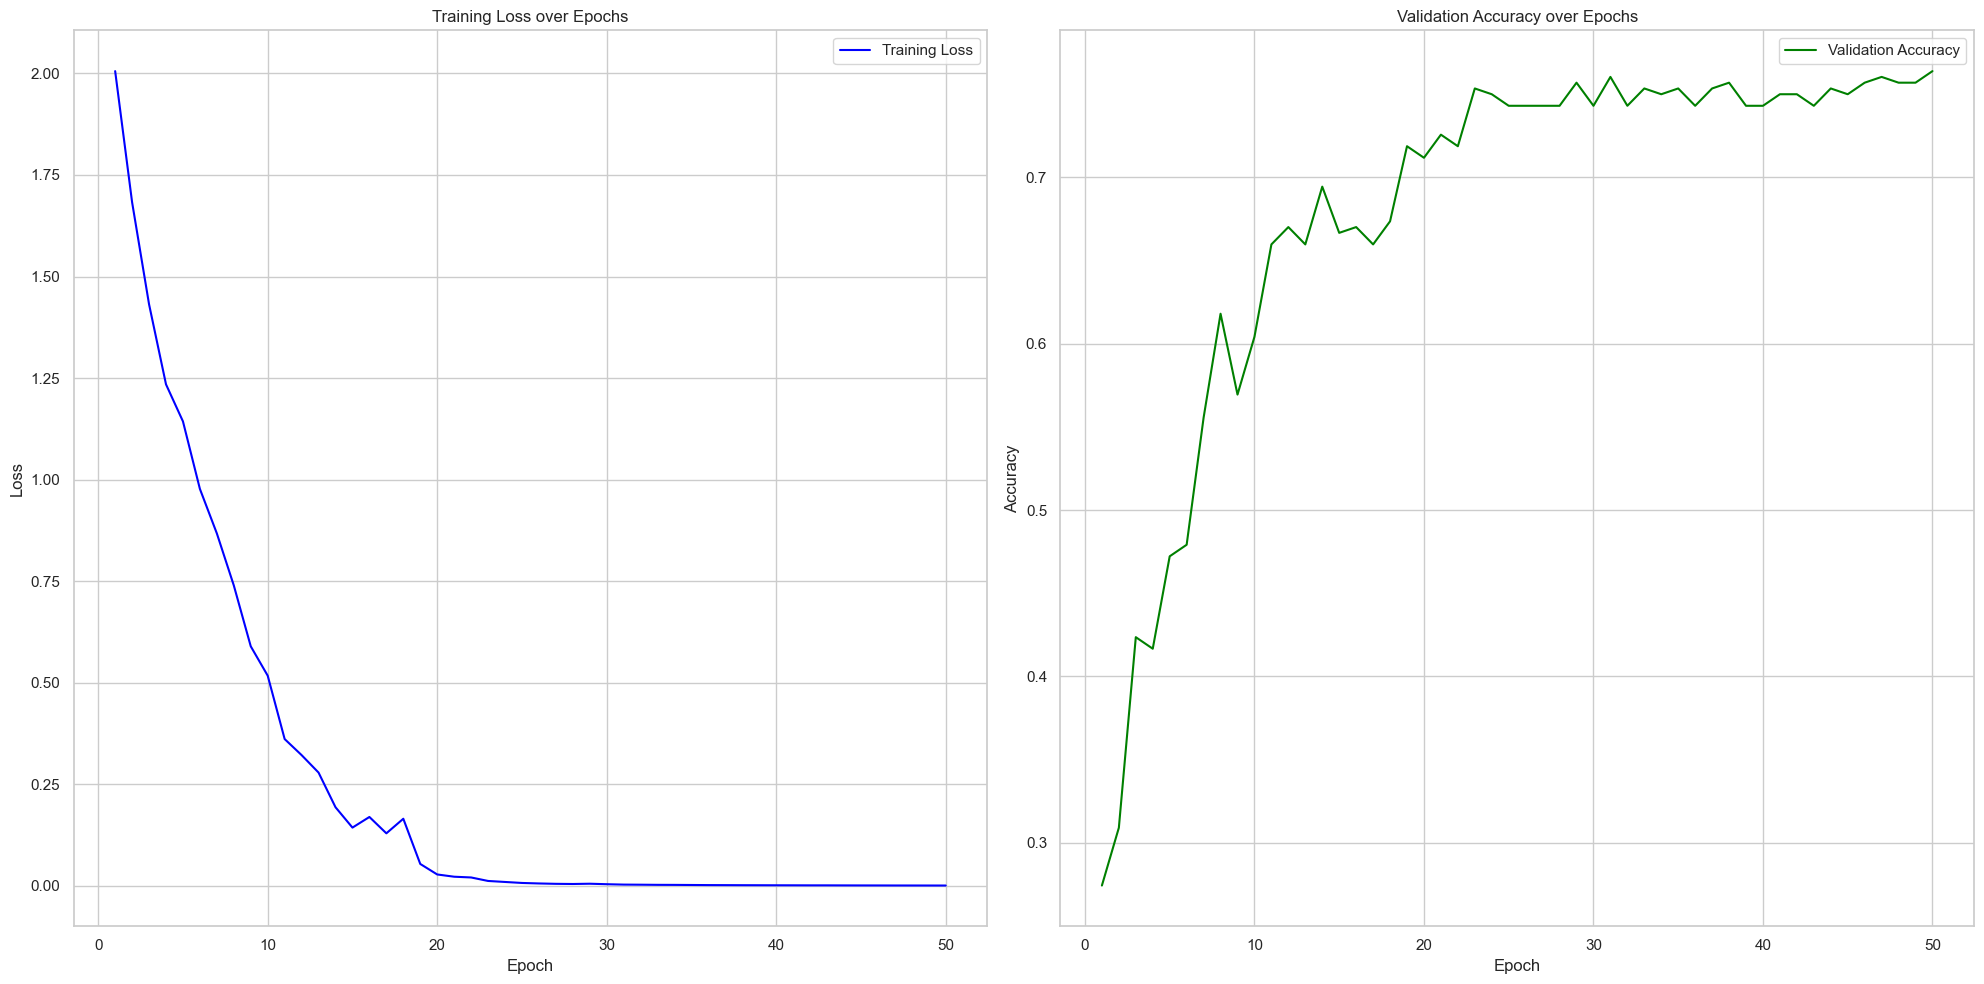

In [20]:
epochs = range(1, 51)
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Training RNN

#### Load the whisper model

In [23]:
whisper_model = whisper.load_model("base")

In [24]:
def transcribe_audio(input_dir):
    transcripts = []
    
    for actor_folder in os.listdir(input_dir):
        actor_path = os.path.join(input_dir, actor_folder)
        if not os.path.isdir(actor_path):
            continue

        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                file_path = os.path.join(actor_path, file)

                # Extract emotion label (5th element in filename)
                parts = file.split("-")
                emotion_label = parts[2]  # e.g., '03'

                # Transcribe audio
                result = whisper_model.transcribe(file_path)
                text = result["text"]
                
                
                # Store filename, text, and label
                transcripts.append((file_path, text, emotion_label))
    return transcripts

In [25]:
import os
import subprocess

os.environ["PATH"] += r";C:\ffmpeg\bin"
result = subprocess.run(['ffmpeg', '-version'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print(result.stdout.decode())

ffmpeg version n7.1.1-9-g652a765ecb-20250506 Copyright (c) 2000-2025 the FFmpeg developers
built with gcc 14.2.0 (crosstool-NG 1.27.0.18_7458341)
configuration: --prefix=/ffbuild/prefix --pkg-config-flags=--static --pkg-config=pkg-config --cross-prefix=x86_64-w64-mingw32- --arch=x86_64 --target-os=mingw32 --enable-gpl --enable-version3 --disable-debug --disable-w32threads --enable-pthreads --enable-iconv --enable-zlib --enable-libfreetype --enable-libfribidi --enable-gmp --enable-libxml2 --enable-lzma --enable-fontconfig --enable-libharfbuzz --enable-libvorbis --enable-opencl --disable-libpulse --enable-libvmaf --disable-libxcb --disable-xlib --enable-amf --enable-libaom --enable-libaribb24 --enable-avisynth --enable-chromaprint --enable-libdav1d --enable-libdavs2 --enable-libdvdread --enable-libdvdnav --disable-libfdk-aac --enable-ffnvcodec --enable-cuda-llvm --enable-frei0r --enable-libgme --enable-libkvazaar --enable-libaribcaption --enable-libass --enable-libbluray --enable-libjxl 

In [26]:
audio_dir = "Audio"
transcripts = transcribe_audio(audio_dir)

C:\Users\pshar\anaconda3\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [27]:
def tokenize(text):
    return text.lower().split()


# extract only the transcripts that is the "text" from the transcripts object
texts = [t[1] for t in transcripts]  

# tokenise the text
tokens = [tokenize(t) for t in texts]
vocab = Counter(token for sentence in tokens for token in sentence)
word2idx = {word: i+1 for i, (word, _) in enumerate(vocab.items())}
word2idx["<PAD>"] = 0
vocab_size = len(word2idx)

#### Create dataset class

In [29]:
class TextDataset(Dataset):
    def __init__(self, transcript_list):
        self.data = transcript_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, text, label = self.data[idx]
        label = int(label) - 1 
        tokens = tokenize(text)
        indices = [word2idx.get(w, 0) for w in tokens]
        return torch.tensor(indices), label

In [30]:
def collate_batch(batch):
    sequences, labels = zip(*batch)
    sequences = pad_sequence(sequences, batch_first=True)
    labels = torch.tensor(labels)
    return sequences, labels

#### RNN module

In [32]:
class TextRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 8) 

    def forward(self, x, return_features=False):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        features = hidden.squeeze(0)  
        if return_features:
            return features
        return self.fc(features)

Assume that the vocab_size = 21
* **Vocabulary size**: 21 (including `<PAD>` at index 0).
* **Word indices**: These are the integer representations of words in the vocabulary.

Consider an example "I am so angry"

* **Tokenized Sentence**: `["i", "am", "so", "angry"]`
* **Numericalized**: Using `word2idx`, this becomes `[1, 2, 3, 4]`.


### **Padding**

* Sentences need to be padded to a fixed length for batch processing. Here, we pad the sentence to a length of 10. Padding is done usnig the collate_batch function.
  
  ```python
  [1, 2, 3, 4, 0, 0, 0, 0, 0, 0]
  ```

  * **Shape**: `(batch_size, seq_len) = (1, 10)` 


#### 1. **Embedding Layer**

```python
self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
```

* **Input**: A sequence of word indices, such as `[1, 2, 3, 4, 0, 0, 0, 0, 0, 0]`.
* **Output**: Each word index is mapped to a dense vector (word embedding).
* **`vocab_size=21`** 
* **embed_dim=50** meaning each word is mapped to a 50-dimensional vector
* **hidden_dim=64**

The embedding layer transforms the input indices into vectors,

An example is given below for your understanding

```python
[1, 2, 3, 4, 0, 0, ...] → [[0.2, -0.1, ..., 0.3], [0.5, 0.1, ..., -0.2], ..., [0.0, 0.0, ..., 0.0]]
```

* **Shape**: The resulting output has the shape `(batch_size, seq_len, embed_dim)` → `(1, 10, 50)`.


#### 2. **LSTM Layer**

```python
self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
```

* **Input**: The embedded sentence with shape `(batch_size, seq_len, embed_dim)` → `(1, 10, 50)`.
* **Output**: The LSTM processes each word vector sequentially and updates its internal state. The output from the LSTM is:

  * The **hidden state**: Shape `(batch_size, seq_len, hidden_dim)` → `(1, 10, 64)`
  * The **cell state**: Contains information to maintain long-term dependencies in the sequence.
 
Since we are intersted in the final hidden state after the entire sequence is processed. the output dimensions is `(batch_size, hidden_dim)` → `(1, 64)`

#### 3. **Fully Connected (Linear) Layer**

```python
self.fc = nn.Linear(hidden_dim, output_dim)
```

* **Input**: The LSTM output, which has a shape of `(batch_size, hidden_dim)` → `(1, 64)`.
* **Output**: The output from the fully connected layer is the predicted emotion scores, with shape `(batch_size, output_dim)` → `(1, 8)` for 8 emotions.

This layer maps the 64-dimensional LSTM hidden state to a 1-dimensional vector with 8 scores, one for each emotion class 

```python
(1, 64) → (1, 8)
```

* **Output Shape**: `(1, 8)`

#### Setting up the RNN model for training

In [151]:
# training dataset using the TextDataset module that accepts the transcripts object generated using whisper

train_text_subset = Subset(TextDataset(transcripts), train_indices)
val_text_subset = Subset(TextDataset(transcripts), val_indices)

train_text_loader = DataLoader(train_text_subset, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_text_loader = DataLoader(val_text_subset, batch_size=32, shuffle=False, collate_fn=collate_batch)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_model = TextRNN(vocab_size=vocab_size, embed_dim=50, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(text_model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

#### Train RNN

In [154]:
train_losses = []
val_accuracies = []

for epoch in range(50):
    text_model.train()
    total_loss = 0
    for sequences, labels in train_text_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = text_model(sequences)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    
    train_losses.append(total_loss / len(train_text_loader))
    print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_text_loader):.4f}")

    
    text_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for sequences, labels in val_text_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = text_model(sequences)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1, Train Loss: 2.0881
Epoch 1, Validation Accuracy: 0.1076
Epoch 2, Train Loss: 2.0876
Epoch 2, Validation Accuracy: 0.1076
Epoch 3, Train Loss: 2.0858
Epoch 3, Validation Accuracy: 0.1111
Epoch 4, Train Loss: 2.0844
Epoch 4, Validation Accuracy: 0.1111
Epoch 5, Train Loss: 2.0844
Epoch 5, Validation Accuracy: 0.1111
Epoch 6, Train Loss: 2.0840
Epoch 6, Validation Accuracy: 0.1111
Epoch 7, Train Loss: 2.0841
Epoch 7, Validation Accuracy: 0.1111
Epoch 8, Train Loss: 2.0821
Epoch 8, Validation Accuracy: 0.1111
Epoch 9, Train Loss: 2.0805
Epoch 9, Validation Accuracy: 0.1111
Epoch 10, Train Loss: 2.0806
Epoch 10, Validation Accuracy: 0.1111
Epoch 11, Train Loss: 2.0798
Epoch 11, Validation Accuracy: 0.1111
Epoch 12, Train Loss: 2.0796
Epoch 12, Validation Accuracy: 0.1111
Epoch 13, Train Loss: 2.0783
Epoch 13, Validation Accuracy: 0.1111
Epoch 14, Train Loss: 2.0783
Epoch 14, Validation Accuracy: 0.1146
Epoch 15, Train Loss: 2.0780
Epoch 15, Validation Accuracy: 0.1146
Epoch 16, Tra

#### Analyse loss and accuracy of RNN

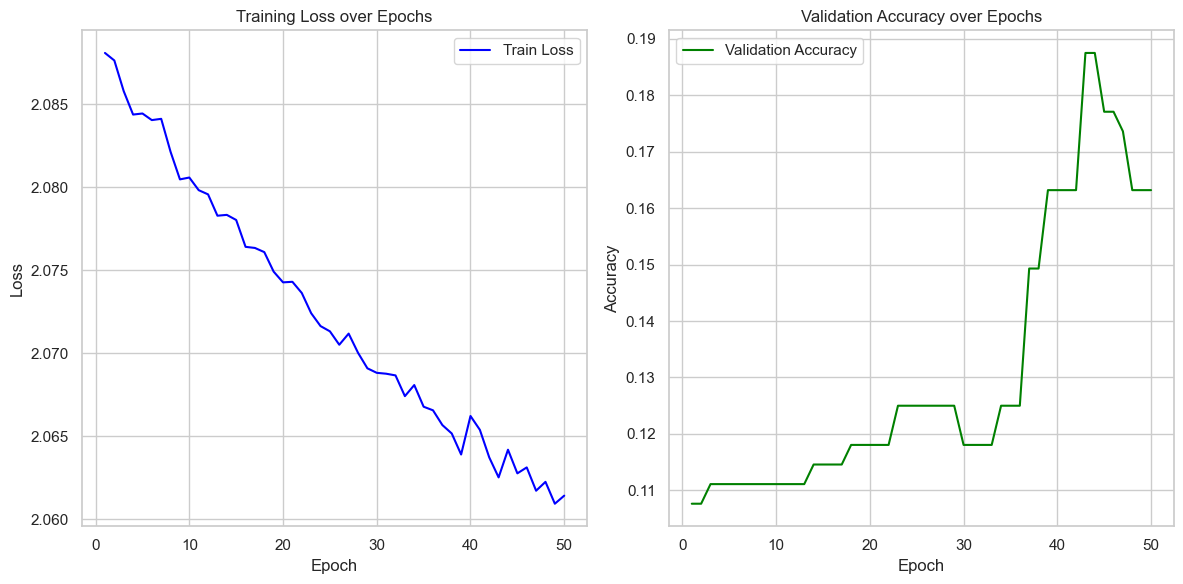

In [157]:
epochs = range(1, 51)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Phase 2

### Fusion Model

#### Creating fusion dataset

In [258]:
transcript_dict = {}

for entry in transcripts:
    file_path, text, label = entry
    filename_stem = os.path.splitext(os.path.basename(file_path))[0]
    transcript_dict[filename_stem] = (text, label)


#### Aligned or sorting the data in order for the fusion model

In [195]:
aligned_text_data = []
aligned_image_files = []

image_dir = "spectrograms"

for image_file in os.listdir(image_dir):
    if not image_file.endswith('.png'):
        continue

    filename_stem = os.path.splitext(image_file)[0]
    if filename_stem in transcript_dict:
        text, label = transcript_dict[filename_stem]
        aligned_text_data.append((filename_stem, text, label))
        aligned_image_files.append(image_file)

#### Creating Class for both text and spectrogram

In [197]:
class AlignedTextDataset(Dataset):
    def __init__(self, aligned_text_data):
        self.data = aligned_text_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        _, text, label = self.data[idx]
        label = int(label) - 1
        tokens = tokenize(text)
        indices = [word2idx.get(w, 0) for w in tokens]
        return torch.tensor(indices), label


class AlignedSpectrogramDataset(Dataset):
    def __init__(self, image_dir, aligned_image_files):
        self.image_dir = image_dir
        self.image_files = aligned_image_files
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, file)
        image = Image.open(img_path).convert("L")
        emotion_id = file.split("-")[2]
        label = emotion_map[emotion_id]
        return self.transform(image), label


In [199]:
class FusionDataset(Dataset):
    def __init__(self, audio_dataset, text_dataset):
        assert len(audio_dataset) == len(text_dataset)
        self.audio_dataset = audio_dataset
        self.text_dataset = text_dataset

    def __len__(self):
        return len(self.audio_dataset)

    def __getitem__(self, idx):
        audio_data, label_a = self.audio_dataset[idx]
        text_data, label_t = self.text_dataset[idx]
        assert label_a == label_t
        return audio_data, text_data, label_a

#### Fusion collate function

In [202]:
def fusion_collate_fn(batch):
    audio_inputs = [item[0] for item in batch]
    text_inputs = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    audio_inputs = torch.stack(audio_inputs)
    text_inputs = pad_sequence(text_inputs, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return audio_inputs, text_inputs, labels

In [204]:
class FusionModel(nn.Module):
    def __init__(self, audio_model, text_model):
        super(FusionModel, self).__init__()
        self.audio_model = audio_model
        self.text_model = text_model
        self.fc = nn.Linear(128 + 64, 8)

    def forward(self, audio_input, text_input):
        audio_feat = self.audio_model(audio_input, return_features=True)
        text_feat = self.text_model(text_input, return_features=True)
        combined = torch.cat((audio_feat, text_feat), dim=1)
        return self.fc(combined)

## Architecture Overview

1. **Audio Feature Extraction (128-dim)**
   The audio model processes raw audio (or its representation, e.g., spectrogram) and outputs a **128-dimensional feature vector**.

   ```python
   audio_feat = self.audio_model(audio_input, return_features=True)  # shape: (batch_size, 128)
   ```

2. **Text Feature Extraction (64-dim)**
   The text model processes text input and outputs a **64-dimensional feature vector** which is he final hidden state from the LTSM

   ```python
   text_feat = self.text_model(text_input, return_features=True)  # shape: (batch_size, 64)
   ```

3. **Fusion**
   The model concatenates the two feature vectors along the feature dimension.

   ```python
   combined = torch.cat((audio_feat, text_feat), dim=1)  # shape: (batch_size, 192)
   ```

   *192 comes from 128 (audio) + 64 (text).*

4. **Final Classification Layer**
   The concatenated 192-dimensional feature is passed through a linear layer to generate logits for 8 emotion classes:

   ```python
   self.fc = nn.Linear(128 + 64, 8) 
   ```

#### Obtaining audio and text datasets

In [238]:
audio_dataset = AlignedSpectrogramDataset(image_dir, aligned_image_files)
text_dataset = AlignedTextDataset(aligned_text_data)

indices = list(range(len(aligned_text_data)))  # aligned_data = list of (audio_file, transcript, label)
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_audio_subset = Subset(audio_dataset, train_indices)
val_audio_subset = Subset(audio_dataset, val_indices)
train_text_subset = Subset(text_dataset, train_indices)
val_text_subset = Subset(text_dataset, val_indices)

#### Creating fusion dataset

In [241]:
train_fusion_dataset = FusionDataset(train_audio_subset, train_text_subset)
val_fusion_dataset = FusionDataset(val_audio_subset, val_text_subset)
train_loader = DataLoader(train_fusion_dataset, batch_size=32, shuffle=True, collate_fn=fusion_collate_fn)
val_loader = DataLoader(val_fusion_dataset, batch_size=32, shuffle=False, collate_fn=fusion_collate_fn)

#### Creating Fusion model using the class

In [244]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion_model = FusionModel(model, text_model).to(device)
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

#### Fusion model training

In [232]:
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(10):
    fusion_model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for audio_images, text_sequences, labels in train_loader:
        audio_images, text_sequences, labels = audio_images.to(device), text_sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = fusion_model(audio_images, text_sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")

    fusion_model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for audio_images, text_sequences, labels in val_loader:
            audio_images, text_sequences, labels = audio_images.to(device), text_sequences.to(device), labels.to(device)
            outputs = fusion_model(audio_images, text_sequences)
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Val Acc = {val_acc:.4f}")

Epoch 1: Train Loss = 5.7376, Train Acc = 0.0642
Epoch 1: Val Acc = 0.0903
Epoch 2: Train Loss = 3.0045, Train Acc = 0.1120
Epoch 2: Val Acc = 0.1667
Epoch 3: Train Loss = 2.1388, Train Acc = 0.1953
Epoch 3: Val Acc = 0.2500
Epoch 4: Train Loss = 1.7106, Train Acc = 0.3160
Epoch 4: Val Acc = 0.2847
Epoch 5: Train Loss = 1.4431, Train Acc = 0.4575
Epoch 5: Val Acc = 0.4062
Epoch 6: Train Loss = 1.2488, Train Acc = 0.5530
Epoch 6: Val Acc = 0.4375
Epoch 7: Train Loss = 1.0801, Train Acc = 0.6536
Epoch 7: Val Acc = 0.4861
Epoch 8: Train Loss = 0.9474, Train Acc = 0.7057
Epoch 8: Val Acc = 0.5208
Epoch 9: Train Loss = 0.8404, Train Acc = 0.7491
Epoch 9: Val Acc = 0.5660
Epoch 10: Train Loss = 0.7425, Train Acc = 0.7943
Epoch 10: Val Acc = 0.5764


#### Analysing Fusion model accuracy and losses

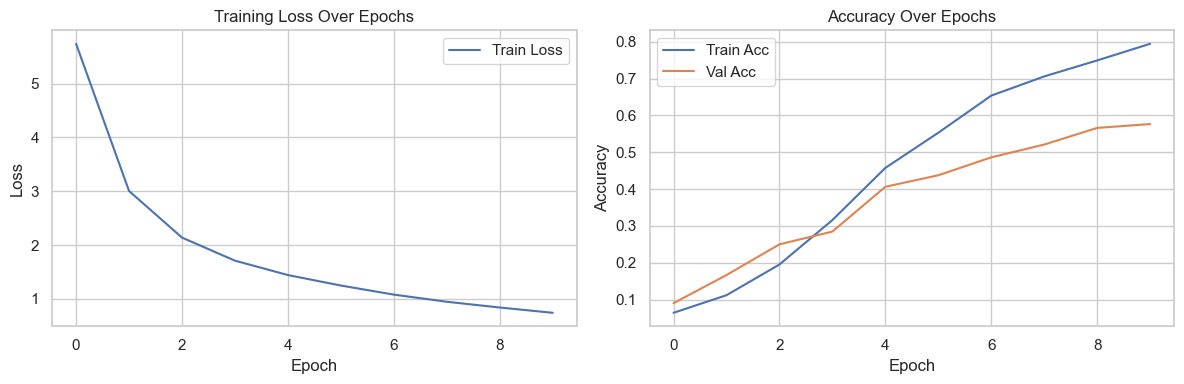

In [236]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusions

### 1. **CNN Model:**

* **Validation Accuracy:** 76%
* The CNN model performed quite well, achieving a validation accuracy of 76%. This suggests that the CNN was effective in capturing patterns in the spectrograms.

### 2. **RNN Model:**

* **Validation Accuracy:** 16%
* The RNN model performed poorly, with a validation accuracy of just 16%. This suggests that the RNN struggled to effectively capture the nuances in the text data or that the preprocessing and tokenization may not have been optimal for textual input.

### 3. **Fusion Model (10 Epochs) - Early fusion:**

* **Train Accuracy:** 79.43%
* **Validation Accuracy:** 57.64%
* The **fusion model**, which combines both audio (via CNN) and text (via RNN), showed a **validation accuracy of 57.64%** after 10 epochs. This is an improvement compared to the RNN alone (16%) but still falls short compared to the CNN model (76%).
* **Key Observations:**

  * The fusion model benefits from the CNN's good performance on the audio data and improves the RNN’s performance on the textual data.
  * The fusion model has a higher validation accuracy than the RNN model on its own, showing that combining the strengths of both audio and text features is better than relying on one modality alone.
  * The validation accuracy of 57.64% indicates that fusion model is effective but hasnt reached the level of CNN model alone. This could be due to the RNN component which is dragging down the overall performance
